# Autonomous Driving - Automatic detection of vehicles on the road for vehicle tracking, vehicle counting, and road incident response

<span style='color:Purple; font-size:20px'> **Description of the Problem Statement** - Autonomous vehicles (AV) and intelligent transport systems (ITS) are the future of road transport. Automatic detection of vehicles on the road in real-time is essential for vehicle tracking, vehicle counting, and road incident response </span>

In [1]:
import os
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import torch 
import shutil
import ultralytics
from ultralytics import YOLO
import seaborn as sns

In [2]:
# !pip install ultralytics

In [3]:
print(ultralytics.__file__)

C:\Users\Sonia\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\__init__.py


<span style="font-size:16px; color:red"> **Inferences** - Installed Ultralytics YOLO (You Only Look Once) object detection model as shown above </span>

<span style='color:Blue; font-size:20px'> **Part-1 : Task** -As the first part of this project, you need to develop an AI model using a deep learning framework that predicts the type of vehicle present in an image as well as localizes the vehicle by rectangular bounding box. </span>

<span style='color:Purple; font-size:18px'> **Task** - 
- **Approach-1:** Using Fine-Tuned YOLO Model for Object Detection
- **Approach-2:** Create a CNN inspired by YOLO architecture for multiple object detection in an image (Completed in another Jupyter Notebook file attached with the project)  </span>

<span style='color:Purple; font-size:16px'> **Task** - **Approach-1** Fine-Tuning YOLO for Object Detection and classification</span>

In [4]:
# Reading labels csv file and loading it into dataframe
label_dataframe = pd.read_csv("labels_new.csv")
label_dataframe.head()

,image_id,class_name,x_min,y_min,x_max,y_max
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45


In [5]:
label_dataframe.shape

(351549, 6)

<span style="font-size:16px; color:red"> **Inferences** - The number of labels entries present in the labels_new.csv file are 351549 and it contains information about the images such as class name, Xmin, Ymin, Xmax, Ymax</span>

<span style='color:Purple; font-size:16px'> **Task** - Fine-Tuning YOLO for Object Detection - Custom Dataset preparation - unique classes for Classification </span>

In [6]:
label_dataframe['class_name'].unique()

array(['pickup_truck', 'car', 'articulated_truck', 'bus', 'motorized_vehicle', 'work_van', 'single_unit_truck', 'pedestrian', 'bicycle', 'non-motorized_vehicle', 'motorcycle'], dtype=object)

In [7]:
# Map class names to IDs
class_map = {name: idx for idx, name in enumerate(label_dataframe['class_name'].unique())}
print(class_map)

{'pickup_truck': 0, 'car': 1, 'articulated_truck': 2, 'bus': 3, 'motorized_vehicle': 4, 'work_van': 5, 'single_unit_truck': 6, 'pedestrian': 7, 'bicycle': 8, 'non-motorized_vehicle': 9, 'motorcycle': 10}


<span style="font-size:16px; color:red"> **Inferences** - The unique classes of vehicles defined in the Custom dataset are mentioned above </span>

<span style='color:Purple; font-size:16px'> **Task** - Fine-Tuning YOLO for Object Detection - Custom Dataset preparation - creating labels files for all images  </span>

In [ ]:
# Group by filename
for image_id, group in label_dataframe.groupby('image_id'):
    label_lines = []
    for _, row in group.iterrows():
        class_id = class_map[row['class_name']]
        x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
        #img_w, img_h = row['img_width'], row['img_height']
        img_w, img_h = 640, 480
        
        
        # Convert to YOLO format
        x_center = ((x_min + x_max) / 2) / img_w
        y_center = ((y_min + y_max) / 2) / img_h
        width = (x_max - x_min) / img_w
        height = (y_max - y_min) / img_h

        line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        label_lines.append(line)

    # Save to .txt file
    #txt_filename = os.path.splitext(filename)[0] + '.txt'
    txt_filename = f"{image_id:08}.txt"
    with open(os.path.join("labels", txt_filename), 'w') as f:
        f.write('\n'.join(label_lines))

<span style="font-size:16px; color:red"> **Inferences** - The labels_new.csv file contains information about all the images present in the dataset. The above step is performed to create individual label file for corresponding image based on image ID and saved in the 'labels' directory</span>

<span style='color:Purple; font-size:16px'> **Task** - Fine-Tuning YOLO for Object Detection - Custom Dataset preparation - reading images from unzipped 'Images' directory and preview of the images  </span>

In [8]:
# Get all image files
images_files = []
for file in os.listdir('Images'):
    if file.endswith(('.jpg', '.png')):
        images_files.append(file)    

In [9]:
len(images_files)

5626

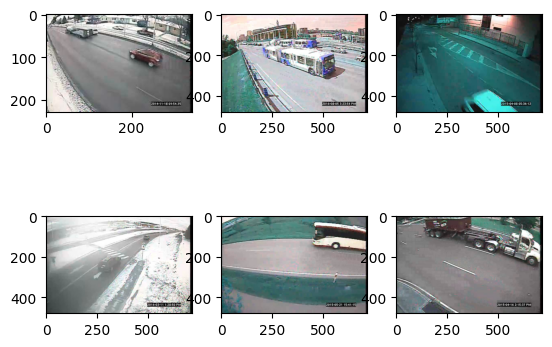

In [10]:
# Load images and create dataset
dataset = []
for count in range(6):
    ax = plt.subplot(2, 3, count+1)
    path = "Images/" + images_files[count]
    image = cv2.imread(path)
    dataset.append(image)
    plt.imshow(image)

<span style="font-size:16px; color:red"> **Inferences** - Understanding the image dataset by reading all file names in the 'Images' directory and displaying some of the sample images using cv2 library </span>

<span style='color:Purple; font-size:16px'> **Task** - Fine-Tuning YOLO for Object Detection - Custom Dataset preparation - split the custom dataset into train and validation  </span>

In [ ]:
# Shuffle and split - Make the dataset split random due to shuffle
# random.seed(42)
# random.shuffle(images_files)

In [ ]:
# Creating directories for train, validation and test - Output directories
# Executed only once for creation of required directories
os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/images/val', exist_ok=True)
os.makedirs('dataset/images/test', exist_ok=True)
os.makedirs('dataset/labels/train', exist_ok=True)
os.makedirs('dataset/labels/val', exist_ok=True)


In [11]:
SPLIT_RATIO = 0.8  # 80% train, 20% validation

In [12]:
split_index = int(len(images_files) * SPLIT_RATIO)
split_index

4500

In [13]:
split_data = {
    "train": images_files[:split_index],
    "val": images_files[split_index:]
}

In [14]:
split_data['train'][8]

'00000008.jpg'

In [ ]:
# Copy images and labels in the train and validation directory
for directory in dirs:
    for img_file in split_data[directory]:
        label_file = img_file.rsplit('.', 1)[0] + ".txt"
        # Copy image
        shutil.copy(os.path.join("Images", img_file),
                    os.path.join("dataset", "images", directory, img_file))
        # Copy label
        shutil.copy(os.path.join("labels", label_file),
                    os.path.join("dataset", "labels", directory, label_file))

In [15]:
len(os.listdir('dataset/images/train'))

4500

In [16]:
len(os.listdir('dataset/images/val'))

1126

In [17]:
len(os.listdir('dataset/labels/train'))

4500

In [18]:
len(os.listdir('dataset/labels/val'))

1126

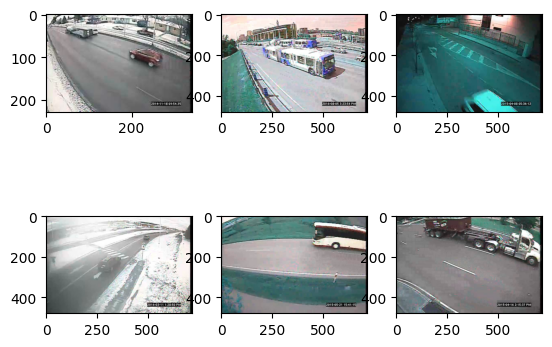

In [19]:
# Load images and create dataset
train_dataset = []
for count in range(6):
    ax = plt.subplot(2, 3, count+1)
    path = "dataset/images/train/" + split_data['train'][count]
    image = cv2.imread(path)
    train_dataset.append(image)
    plt.imshow(image)

<span style="font-size:16px; color:red"> **Inferences** - Images are split into train and validation and copied in their destination directories and preview of the images from the train is also shown in the form of pictures</span>

<span style='color:Purple; font-size:16px'> **Task** - Fine-Tuning YOLO for Object Detection - Custom Dataset preparation - Pre-process train and validation images  </span>

In [20]:
# Function to preprocess the image
def preprocess_image(image_path):
    
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image from BGR to RGB (as YOLOv5 uses RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to 640x640 (YOLOv5 expects a 640x640 input)
    img_resized = cv2.resize(img, (640, 640))

    return img_resized

In [21]:
train_data_images = len(split_data['train'])
print(train_data_images)

4500


In [22]:
train_img_resized = []
for i in range(train_data_images):
    image_path = "dataset/images/train/" + split_data['train'][i]
    train_img_resized.append(preprocess_image(image_path))
    
print(train_img_resized[0].shape)
print(len(train_img_resized))

(640, 640, 3)
4500


In [23]:
val_data_images = len(split_data['val'])
print(val_data_images)

1126


In [24]:
val_img_resized = []
for i in range(val_data_images):
    image_path = "dataset/images/val/" + split_data['val'][i]
    val_img_resized.append(preprocess_image(image_path))
    
print(val_img_resized[0].shape)
print(len(val_img_resized))

(640, 640, 3)
1126


<span style="font-size:16px; color:red"> **Inferences** - Train and Validation images are pre-processed to the required format accepted by YOLO model such as color(RGB) and size as 640x640x3 (3 channels - RGB)</span>

<span style='color:Purple; font-size:16px'> **Task** - Fine-Tuning YOLO for Object Detection - Train and validation the model on Custom Dataset </span>

In [25]:
os.getcwd()

'C:\\Users\\Sonia\\Python_Programs\\Capstone-01\\01_Capstone-try1'

In [26]:
# Load a pre-trained YOLOv8 model for object detection
model = YOLO('yolov8n.pt')  # 'n' = nano model, very small and fast. You can also use yolov8s.pt, yolov8m.pt, etc.


In [27]:
# Train the model
model.train(data="custom_data.yaml", epochs=5, imgsz=640, batch=16)


New https://pypi.org/project/ultralytics/8.3.140 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.114  Python-3.12.5 torch-2.7.0+cpu CPU (Intel Core(TM) i7-7500U 2.70GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=custom_data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False,

train: Scanning C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\labels\train.cache... 4500 images, 

train: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\train\00000001.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0758]
train: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\train\00000012.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0508]
train: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\train\00000019.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0688]
train: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\train\00000026.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0266]
train: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\train\00000032.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0047]
train: C:\Users\Sonia\Python_Programs\Capstone-01\


C:\Users\Sonia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\labels\val.cache... 1126 images, 0 ba

val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004527.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0289      1.0906]
val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004537.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0914      1.0367      1.0516      1.0945]
val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004539.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0187]
val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004542.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0578]
val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004544.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0633      1.0469      1.0086


C:\Users\Sonia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train7
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      2.283      3.867      1.789         67        640: 100%|██████████| 235/235 [40:34<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [02:34


                   all        941       2662      0.649     0.0888     0.0809     0.0441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.918       3.01      1.511         82        640: 100%|██████████| 235/235 [38:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [02:30


                   all        941       2662      0.767      0.136      0.125     0.0751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.787      2.653      1.417         70        640: 100%|██████████| 235/235 [38:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [02:27


                   all        941       2662      0.553      0.132      0.125     0.0758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.681      2.364      1.358         70        640: 100%|██████████| 235/235 [39:28<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [02:26


                   all        941       2662      0.456      0.185       0.15     0.0923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.571      2.136      1.297         58        640: 100%|██████████| 235/235 [38:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [02:28


                   all        941       2662       0.57      0.217      0.206      0.126

5 epochs completed in 3.465 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 6.2MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics 8.3.114  Python-3.12.5 torch-2.7.0+cpu CPU (Intel Core(TM) i7-7500U 2.70GHz)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [02:00


                   all        941       2662       0.57      0.217      0.206      0.126
          pickup_truck        250        336      0.353        0.5      0.395      0.259
                   car        775       1746      0.533      0.498      0.483      0.303
     articulated_truck         51         60      0.471      0.342      0.335      0.196
                   bus         93        106      0.481      0.821      0.705      0.459
     motorized_vehicle        154        190      0.287     0.0737     0.0543     0.0267
              work_van         76         79      0.246     0.0334     0.0876     0.0574
     single_unit_truck         45         47     0.0704     0.0213      0.051     0.0251
            pedestrian         28         50          1          0     0.0183    0.00379
               bicycle         19         21      0.829     0.0952      0.131     0.0516
 non-motorized_vehicle         12         12          1          0   0.000345   0.000276
            motorcycl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001A85BFC3560>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,  

In [28]:
# Load fine-tuned YOLO model
model_best = YOLO('runs/detect/train5/weights/best.pt')

In [29]:
# Validate model performance on validation set
metrics = model_best.val(data="custom_data.yaml")

Ultralytics 8.3.114  Python-3.12.5 torch-2.7.0+cpu CPU (Intel Core(TM) i7-7500U 2.70GHz)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 209.798.3 MB/s, size: 31.9 KB)


val: Scanning C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\labels\val.cache... 1126 images, 0 ba

val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004527.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0289      1.0906]
val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004537.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0914      1.0367      1.0516      1.0945]
val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004539.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0187]
val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004542.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0578]
val: C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\val\00004544.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0633      1.0469      1.0086


C:\Users\Sonia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [01:44


                   all        941       2662      0.649     0.0888     0.0809     0.0441
          pickup_truck        250        336       0.13      0.113       0.06     0.0325
                   car        775       1746       0.28      0.225      0.172      0.087
     articulated_truck         51         60          0          0     0.0193      0.011
                   bus         93        106      0.487      0.623      0.575      0.328
     motorized_vehicle        154        190      0.243     0.0158      0.026     0.0104
              work_van         76         79          1          0     0.0344     0.0146
     single_unit_truck         45         47          1          0    0.00285    0.00146
            pedestrian         28         50          1          0          0          0
               bicycle         19         21          1          0   0.000395    0.00013
 non-motorized_vehicle         12         12          1          0          0          0
            motorcycl

In [30]:
metrics.results_dict

{'metrics/precision(B)': np.float64(0.6491450012595851),
 'metrics/recall(B)': np.float64(0.08878292107875745),
 'metrics/mAP50(B)': np.float64(0.08090781799742308),
 'metrics/mAP50-95(B)': np.float64(0.044127771759031216),
 'fitness': np.float64(0.04780577638287041)}

<span style="font-size:16px; color:red"> **Inferences** - 
- Precision is about 65% 
- YOLO model is trained above using custom_data.yaml file having the paths of train, validation and test dataset    with the description of classes. The best trained model at the path 'runs/detect/train5/weights/best.pt' is further used for the predictions
- **Note** - The number of epochs used are less due to the constraint on the memory and computing power of the laptop
- Using validation dataset, predictions are made and performance metrics are shown above depicting Precision, Recall, mAP50(B), mAP50-95(B), fitness  </span>

<span style='color:Purple; font-size:16px'> **Task** - Fine-Tuning YOLO for Object Detection - Inference on the best models on Custom Dataset </span>

In [37]:
# Inference Results

image_path1 = 'dataset/images/train/00000001.jpg'
image_path2 = 'dataset/images/train/00000211.jpg'

resized_image = preprocess_image(image_path1)
# Run object detection on an image
results = model(resized_image)

# Access the first prediction result
result = results[0]
# Print number of detections
print(f"Detections: {len(result.boxes)}")

# Print detection details
for box in result.boxes:
    print("Class:", model.names[int(box.cls)])
    print("Confidence:", float(box.conf))
    print("Bounding Box [x1, y1, x2, y2]:", box.xyxy[0].tolist())

# Show results
result.show()
plt.savefig('yolo_fig1')



0: 640x640 1 bus, 194.2ms
Speed: 5.5ms preprocess, 194.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Detections: 1
Class: bus
Confidence: 0.4946190118789673
Bounding Box [x1, y1, x2, y2]: [116.41798400878906, 206.27667236328125, 539.2171630859375, 422.79364013671875]


<Figure size 640x480 with 0 Axes>

<span style="font-size:16px; color:red"> **Inferences** - The result of the detection on the given image is shown above - Speed, Detections, Class, Confidence and Bounding boxes </span>

<span style='color:Purple; font-size:16px'> **Task** - Fine-Tuning YOLO for Object Detection - Testing using the best models on Custom Dataset </span>

In [38]:
# Run prediction on test images folder
test_results = model.predict(source = 'C:\\Users\\Sonia\\Python_Programs\\Capstone-01\\01_Capstone-try1\\dataset\\images\\test',
                             save = True, conf = 0.25)

# You can also access predictions programmatically
for result in test_results:
    print("Boxes:", result.boxes.xyxy)  # bounding boxes
    print("Scores:", result.boxes.conf)  # confidence scores
    print("Classes:", result.boxes.cls)  # predicted class ids
    # Show results
    result.show()



image 1/10 C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\test\00000010.jpg: 448x640 2 cars, 184.7ms
image 2/10 C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\test\00000020.jpg: 448x640 (no detections), 163.8ms
image 3/10 C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\test\00000030.jpg: 448x640 1 pickup_truck, 2 cars, 127.9ms
image 4/10 C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\test\00000040.jpg: 448x640 2 cars, 108.1ms
image 5/10 C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\test\00000050.jpg: 448x640 2 pickup_trucks, 104.0ms
image 6/10 C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\test\00004530.jpg: 448x640 (no detections), 103.3ms
image 7/10 C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\test\00004548.jpg: 448x640 1 car, 106.2ms
image 8/10 C:\Users\Sonia\Python_Programs\Capstone-01\

<span style="font-size:16px; color:red"> **Inferences** - The result of the detection on the given test images is shown above - Scores, Class and Bounding boxes. The output images are saved in the output screenshot document </span>

<span style='color:Purple; font-size:22px'> **Part-2 : Task** - As the second part of this project, you need to analyze the usage of autopilot and its effect on road safety. </span>

<span style='color:Purple; font-size:18px'> **Task- Initial Data Exploration** - Perform data quality checks by checking for missing values, duplicate values and others </span>

In [39]:
tesla_dataframe = pd.read_csv('Tesla - Deaths.csv')

In [40]:
tesla_dataframe.head()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230118162813/ht...,NaN,NaN,NaN,NaN,NaN
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230109041434/ht...,NaN,Taren Singh Lal,NaN,NaN,NaN
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,-,1,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230107232745/ht...,NaN,NaN,NaN,NaN,NaN
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,NaN,NaN,NaN,NaN,NaN
4,290.0,2022.0,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,-,-,-,...,-,-,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,NaN,NaN,NaN,NaN,NaN


In [41]:
tesla_dataframe.tail()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,NaN,NaN,NaN,NaN,NaN,"Note: AutoPilot released Oct 14, 2015",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="font-size:16px; color:red"> **Inferences** - The dataset 'Tesla - Deaths.csv' is loaded and dataframe 'tesla_dataframe' is created and viewed using 'head' and 'tail' functions</span>

In [42]:
tesla_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 24 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Case #                                                                294 non-null    float64
 1   Year                                                                  294 non-null    float64
 2   Date                                                                  294 non-null    object 
 3    Country                                                              294 non-null    object 
 4    State                                                                294 non-null    object 
 5    Description                                                          295 non-null    object 
 6    Deaths                                                               299 non-null    float64
 7  

In [43]:
tesla_dataframe.isnull().sum()

Case #                                                                   13
Year                                                                     13
Date                                                                     13
 Country                                                                 13
 State                                                                   13
 Description                                                             12
 Deaths                                                                   8
 Tesla driver                                                            13
 Tesla occupant                                                          17
 Other vehicle                                                           12
 Cyclists/ Peds                                                          11
 TSLA+cycl / peds                                                        10
 Model                                                                   11
 Autopilot c

<span style="font-size:16px; color:red"> **Inferences** - The null values are found in the dataframe 'tesla_dataframe' and would be handled later in the flow of code changes below</span>

In [44]:
tesla_dataframe.shape

(307, 24)

In [45]:
tesla_dataframe.columns

Index(['Case #', 'Year', 'Date', ' Country ', ' State ', ' Description ',
       ' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Model ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ',
       'Unnamed: 16', 'Unnamed: 17', ' Source ', ' Note ', ' Deceased 1 ',
       ' Deceased 2 ', ' Deceased 3 ', ' Deceased 4 '],
      dtype='object')

In [46]:
tesla_dataframe.size

7368

<span style="font-size:16px; color:red"> **Inferences** - The total number of rows present in the dataframe is **307** and total number of columns (features) are **24**. The names of the columns are displayed above</span>

<span style='color:Purple; font-size:16px'> **Task** - Remove duplicates from the tesla dataframe </span>

In [47]:
tesla_dataframe.duplicated().sum()

np.int64(4)

In [48]:
tesla_dataframe[tesla_dataframe.duplicated()]

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
tesla_dataframe.drop_duplicates(inplace = True)

In [50]:
tesla_dataframe.duplicated().sum()

np.int64(0)

In [51]:
tesla_dataframe.reset_index(inplace = True)

In [52]:
tesla_dataframe = tesla_dataframe.drop(columns=['index'], axis=1)

In [53]:
tesla_dataframe.shape

(303, 24)

In [54]:
tesla_dataframe.head()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230118162813/ht...,NaN,NaN,NaN,NaN,NaN
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230109041434/ht...,NaN,Taren Singh Lal,NaN,NaN,NaN
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,-,1,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230107232745/ht...,NaN,NaN,NaN,NaN,NaN
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,NaN,NaN,NaN,NaN,NaN
4,290.0,2022.0,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,-,-,-,...,-,-,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,NaN,NaN,NaN,NaN,NaN


In [55]:
tesla_df_category = tesla_dataframe.select_dtypes(include='object').columns
tesla_df_category

Index(['Date', ' Country ', ' State ', ' Description ', ' Tesla driver ',
       ' Tesla occupant ', ' Other vehicle ', ' Cyclists/ Peds ',
       ' TSLA+cycl / peds ', ' Model ', ' Autopilot claimed ',
       ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ',
       'Unnamed: 16', 'Unnamed: 17', ' Source ', ' Note ', ' Deceased 1 ',
       ' Deceased 2 ', ' Deceased 3 '],
      dtype='object')

<span style="font-size:16px; color:red"> **Inferences** - Duplicate values found in the datset and thereby removed adequately as shown above </span>

<span style='color:Purple; font-size:16px'> **Task** - Remove any columns that might not be relevant for the analysis </span>

In [56]:
# Deceased columns have names of the deceased persons in the accidents - hence removed from the analysis
tesla_dataframe = tesla_dataframe.drop([' Deceased 1 ', ' Deceased 2 ', ' Deceased 3 ', ' Deceased 4 '], axis = 1)

In [57]:
# 'Note' column is blank in 298 cases out of 307 - hence removed from the analysis
tesla_dataframe = tesla_dataframe.drop([' Note '], axis = 1)

In [58]:
tesla_dataframe.columns

Index(['Case #', 'Year', 'Date', ' Country ', ' State ', ' Description ',
       ' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Model ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ',
       'Unnamed: 16', 'Unnamed: 17', ' Source '],
      dtype='object')

<span style="font-size:16px; color:red"> **Inferences** - The columns that are not required for the analysis of the problem statement are removed as part of Feature Selection </span>

<span style='color:Purple; font-size:16px'> **Task** - Fill the missing values and change the data type of the following columns
</span>

In [59]:
cols_datatype_chng = [' Tesla driver ', ' Tesla occupant ', ' Other vehicle ', ' Cyclists/ Peds ',
                     ' TSLA+cycl / peds ', ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ']

In [60]:
# replace '-' to '0' in the above columns of the dataframe
tesla_dataframe[cols_datatype_chng] = tesla_dataframe[cols_datatype_chng].replace([' - ', '-', ' '], '0')

In [61]:
# fillna with '0' in the above columns of the dataframe
tesla_dataframe[cols_datatype_chng] = tesla_dataframe[cols_datatype_chng].fillna('0')

In [62]:
tesla_dataframe[' Tesla driver '].unique()

array(['  1 ', '0', '  28 ', '  89 ', '  117 ', '  6 ', '2014'], dtype=object)

In [63]:
tesla_dataframe.head(2)

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,0,0,0,1,-,0,0,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230118162813/ht...
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1,0,0,0,1,-,0,0,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230109041434/ht...


In [64]:
tesla_dataframe[cols_datatype_chng].isnull().sum()

Tesla driver                        0
Tesla occupant                      0
Other vehicle                       0
Cyclists/ Peds                      0
TSLA+cycl / peds                    0
Autopilot claimed                   0
Verified Tesla Autopilot Deaths     0
dtype: int64

In [65]:
# Convert above mentioned columns datatype from object to float32
tesla_dataframe[cols_datatype_chng] = tesla_dataframe[cols_datatype_chng].astype('float32')

In [66]:
tesla_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 19 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Case #                                                                294 non-null    float64
 1   Year                                                                  294 non-null    float64
 2   Date                                                                  294 non-null    object 
 3    Country                                                              294 non-null    object 
 4    State                                                                294 non-null    object 
 5    Description                                                          295 non-null    object 
 6    Deaths                                                               299 non-null    float64
 7  

In [67]:
# the below columns are having website address, hence removed and not used in analysis
tesla_dataframe = tesla_dataframe.drop(['Unnamed: 16', 'Unnamed: 17', ' Source '], axis = 1)

In [68]:
tesla_dataframe.columns

Index(['Case #', 'Year', 'Date', ' Country ', ' State ', ' Description ',
       ' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Model ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '],
      dtype='object')

In [69]:
tesla_dataframe.isnull().sum()[tesla_dataframe.isnull().sum() > 0]

Case #                                                                  9
Year                                                                    9
Date                                                                    9
 Country                                                                9
 State                                                                  9
 Description                                                            8
 Deaths                                                                 4
 Model                                                                  7
 Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO     7
dtype: int64

In [70]:
tesla_dataframe[' Deaths '] = tesla_dataframe[' Deaths '].fillna(0)

In [71]:
tesla_dataframe[' Deaths '].dtypes

dtype('float64')

In [72]:
col_name =  ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '
tesla_dataframe[col_name] = tesla_dataframe[col_name].replace([' - ', '-', ' '], '0')
tesla_dataframe[col_name] = tesla_dataframe[col_name].fillna('0')
tesla_dataframe[col_name] = tesla_dataframe[col_name].astype('float32')

In [73]:
tesla_dataframe[' Model '].unique()

array([' - ', ' Y ', '  1 ', '  2 ', '  3 ', ' S ', ' X ', nan, '  50 ', '2019'], dtype=object)

In [74]:
tesla_dataframe[' Model '] = tesla_dataframe[' Model '].fillna('0')
tesla_dataframe[' Model '] = tesla_dataframe[' Model '].replace(' - ', '0')

In [75]:
tesla_dataframe['Year'].unique()

array([       2022,        2020,        2021,         202,        2019,        2018,        2017,        2016,        2015,        2014,        2013,         nan])

In [76]:
tesla_dataframe[tesla_dataframe['Year'] == 202]

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
162,132.0,202.0,9/17/2020,USA,GA,"Car loses control, hits bus shelter",1.0,0.0,0.0,0.0,1.0,1.0,3,1.0,0.0,1.0


In [77]:
# Corrected the year to 2020 by seeing the Date field '9/17/2020'
tesla_dataframe.loc[162, 'Year'] = 2020

In [78]:
tesla_dataframe.loc[162]

Case #                                                                                                  132.0
Year                                                                                                   2020.0
Date                                                                                                9/17/2020
 Country                                                                                                 USA 
 State                                                                                                    GA 
 Description                                                             Car loses control, hits bus shelter 
 Deaths                                                                                                   1.0
 Tesla driver                                                                                             0.0
 Tesla occupant                                                                                           0.0
 Other veh

In [79]:
tesla_dataframe[tesla_dataframe['Year'].isnull()] 

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
294,NaN,NaN,NaN,NaN,NaN,NaN,92.0,28.0,7.0,29.0,20.0,61.0,0,8.0,3.0,3.0
295,NaN,NaN,NaN,NaN,NaN,NaN,261.0,89.0,41.0,101.0,26.0,149.0,0,30.0,16.0,24.0
296,NaN,NaN,NaN,NaN,NaN,NaN,353.0,117.0,48.0,130.0,46.0,210.0,0,38.0,19.0,27.0
297,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
298,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,118.0,0.0
299,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2022.0,0.0
300,NaN,NaN,NaN,NaN,NaN,NaN,3.0,6.0,5.0,16.0,11.0,21.0,50,47.0,75.0,0.0
301,NaN,NaN,NaN,NaN,NaN,NaN,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019,2020.0,2021.0,0.0
302,NaN,NaN,NaN,NaN,NaN,"Note: AutoPilot released Oct 14, 2015",0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0


In [80]:
tesla_dataframe[tesla_dataframe['Year'].isnull()].count()

Case #                                                                  0
Year                                                                    0
Date                                                                    0
 Country                                                                0
 State                                                                  0
 Description                                                            1
 Deaths                                                                 9
 Tesla driver                                                           9
 Tesla occupant                                                         9
 Other vehicle                                                          9
 Cyclists/ Peds                                                         9
 TSLA+cycl / peds                                                       9
 Model                                                                  9
 Autopilot claimed                    

<span style="font-size:16px; color:red"> **Inferences** - The missing values (NA) are replaced with '0' and ' - ', '-', ' ' are also replaced with '0' for further analysis </span>

In [81]:
tesla_dataframe.tail(9)

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
294,NaN,NaN,NaN,NaN,NaN,NaN,92.0,28.0,7.0,29.0,20.0,61.0,0,8.0,3.0,3.0
295,NaN,NaN,NaN,NaN,NaN,NaN,261.0,89.0,41.0,101.0,26.0,149.0,0,30.0,16.0,24.0
296,NaN,NaN,NaN,NaN,NaN,NaN,353.0,117.0,48.0,130.0,46.0,210.0,0,38.0,19.0,27.0
297,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
298,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,118.0,0.0
299,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2022.0,0.0
300,NaN,NaN,NaN,NaN,NaN,NaN,3.0,6.0,5.0,16.0,11.0,21.0,50,47.0,75.0,0.0
301,NaN,NaN,NaN,NaN,NaN,NaN,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019,2020.0,2021.0,0.0
302,NaN,NaN,NaN,NaN,NaN,"Note: AutoPilot released Oct 14, 2015",0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0


In [82]:
# Remove last 9 rows as it doesn't correspond to any date/state/country for a specific incident
tesla_dataframe = tesla_dataframe[:-9]

In [83]:
tesla_dataframe.tail()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
289,5.0,2014.0,7/14/2014,USA,CA,Tesla kills motorcyclist,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
290,4.0,2014.0,7/4/2014,USA,CA,Thief crashes stolen Tesla,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
291,3.0,2014.0,7/4/2014,USA,CA,Tesla rear ends stopped car,3.0,0.0,0.0,3.0,0.0,0.0,0,0.0,0.0,0.0
292,2.0,2013.0,11/2/2013,USA,CA,Tesla kills cyclist,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
293,1.0,2013.0,4/2/2013,USA,CA,Tesla veers into opposite lane,2.0,0.0,0.0,2.0,0.0,0.0,S,0.0,0.0,0.0


In [84]:
tesla_dataframe[' Country '].isnull().sum()

np.int64(0)

In [85]:
tesla_dataframe[tesla_dataframe[' Country '].isnull()]

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO


<span style="font-size:16px; color:red"> **Inferences** - Remove last 9 rows as it doesn't correspond to any date/state/country for a specific incident for further analysis </span>

<span style='color:purple;font-size:18px'> **Task** - Handling Outliers </span>

In [86]:
tesla_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 16 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Case #                                                                294 non-null    float64
 1   Year                                                                  294 non-null    float64
 2   Date                                                                  294 non-null    object 
 3    Country                                                              294 non-null    object 
 4    State                                                                294 non-null    object 
 5    Description                                                          294 non-null    object 
 6    Deaths                                                               294 non-null    float64
 7  

In [87]:
cols_numerical = tesla_dataframe.select_dtypes(exclude = 'object').columns
cols_numerical

Index(['Case #', 'Year', ' Deaths ', ' Tesla driver ', ' Tesla occupant ',
       ' Other vehicle ', ' Cyclists/ Peds ', ' TSLA+cycl / peds ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '],
      dtype='object')

In [88]:
# Remove the columns 'Case #', 'Year' from the Outlier analysis
cols_numerical = cols_numerical[2:]
cols_numerical

Index([' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Autopilot claimed ',
       ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '],
      dtype='object')

In [89]:
type(tesla_dataframe[' Tesla occupant '])

pandas.core.series.Series

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]


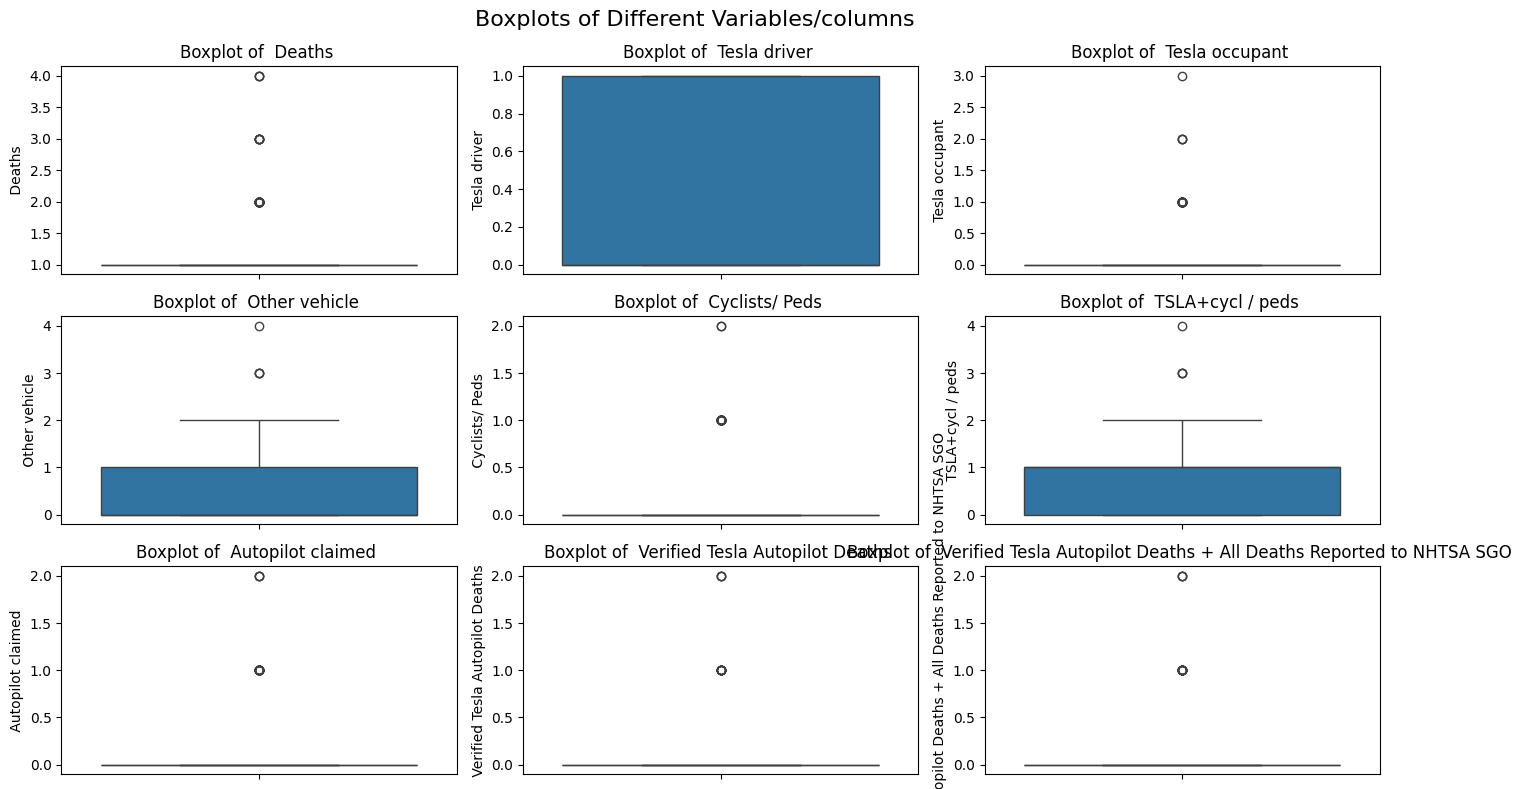

In [91]:
# Create subplots (3 row, 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(14, 8))
# Flatten the axes array for easy iteration
axes = axes.flatten()
print(axes)
fig.suptitle("Boxplots of Different Variables/columns", fontsize=16)
# Plot each column's boxplot in a subplot
for index, col in enumerate(cols_numerical):
    sns.boxplot(y = tesla_dataframe[col], ax = axes[index])
    axes[index].set_title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - No outlier is found in this dataset. These are actual values of total number of persons or vehicles impacted by the accident.  </span>

<span style='color:Purple; font-size:18px'> **Task** - Bivariate Analysis - using seaborn pairplot - To plot multiple pairwise bivariate distributions in a dataset</span>

In [92]:
cols = tesla_dataframe.columns
cols

Index(['Case #', 'Year', 'Date', ' Country ', ' State ', ' Description ',
       ' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Model ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '],
      dtype='object')

In [93]:
len(cols)

16

In [94]:
tesla_dataframe_pairplot_df1 = tesla_dataframe[[' Deaths ', ' Tesla driver ', ' Tesla occupant ']]
tesla_dataframe_pairplot_df2 = tesla_dataframe[[' Other vehicle ',' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Tesla driver ']]
tesla_dataframe_pairplot_df3 = tesla_dataframe[[' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ', ' Tesla driver ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ']]


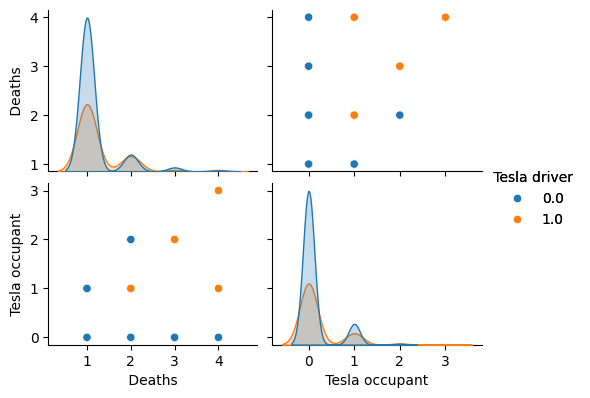

In [95]:
sns.pairplot(tesla_dataframe_pairplot_df1, hue = ' Tesla driver ', height=2).add_legend()
plt.show()

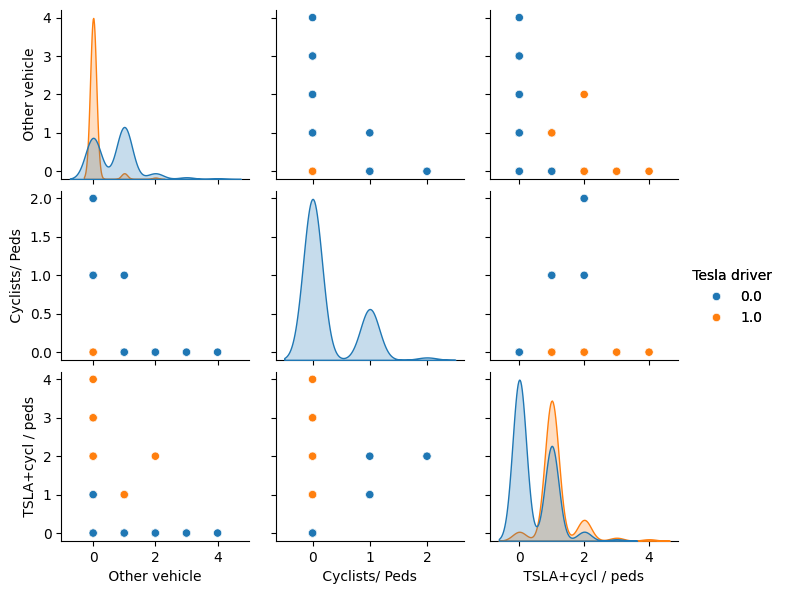

In [96]:
sns.pairplot(tesla_dataframe_pairplot_df2, hue = ' Tesla driver ', height=2).add_legend()
plt.show()

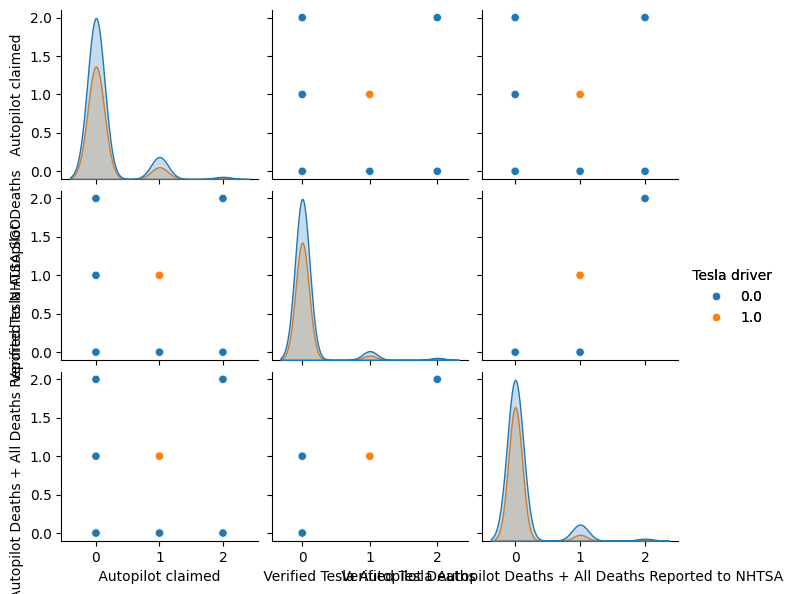

In [97]:
sns.pairplot(tesla_dataframe_pairplot_df3, hue = ' Tesla driver ', height=2).add_legend()
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - Bivariate analysis
- 'Tesla Driver' is depicted in 'orange' color and it shows relationship with the other columns/features
- The above plot shows the linear and other relationship between the pair of variables 
</span>

<span style='color:Purple; font-size:18px'> **Task** - Correlation between various features of dataset </span>

In [98]:
cols_numerical

Index([' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Autopilot claimed ',
       ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '],
      dtype='object')

In [99]:
corr_matrix = tesla_dataframe.corr(numeric_only=True)

<span style='color:Purple; font-size:18px'> **Task** - Heatmap - Correlation between various features of dataset </span>

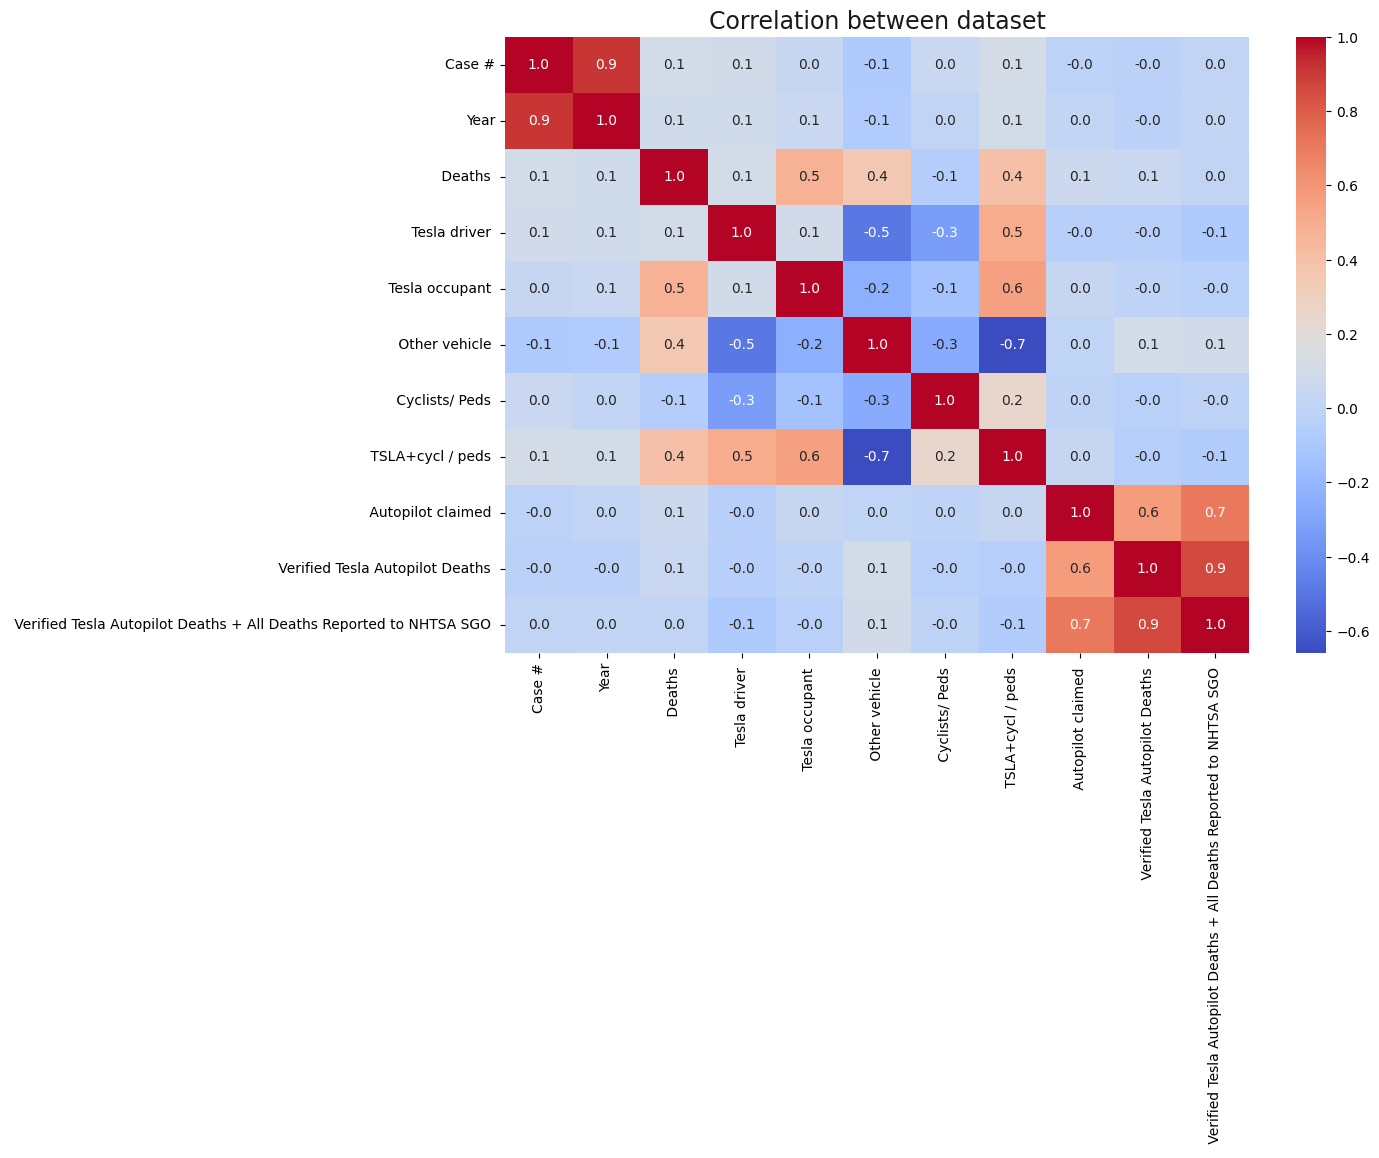

In [100]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Correlation between dataset",fontsize=17,c="k")
plt.show()

<span style="font-size:16px; color:red"> **Inferences** 
- ' Verified Tesla Autopilot Deaths ' and ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ' are positively correlated (0.9)
- ' Autopilot claimed ' and ' Verified Tesla Autopilot Deaths ' are postively correlated (0.6)
- ' Autopilot claimed ' and ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ' are positively correlated (0.7)
- ' TSLA+cycl / peds ' and ' Other vehicle ' are negatively correlated (-0.7)
- ' Tesla occupant ' and ' Deaths ' are positively correlated (0.5)
</span>

In [101]:
tesla_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 16 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Case #                                                                294 non-null    float64
 1   Year                                                                  294 non-null    float64
 2   Date                                                                  294 non-null    object 
 3    Country                                                              294 non-null    object 
 4    State                                                                294 non-null    object 
 5    Description                                                          294 non-null    object 
 6    Deaths                                                               294 non-null    float64
 7  

In [102]:
cols1 = [' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ', ' Cyclists/ Peds ', 
        ' TSLA+cycl / peds ', ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ',
        ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO ']
tesla_dataframe[cols1].describe()


,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,1.200680,0.397959,0.163265,0.442177,0.156463,0.714286,0.129252,0.064626,0.091837
std,0.513171,0.490312,0.421938,0.651899,0.382210,0.666098,0.365250,0.284839,0.322746
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,4.000000,1.000000,3.000000,4.000000,2.000000,4.000000,2.000000,2.000000,2.000000


<span style="font-size:16px; color:red"> **Inferences** - Basic statistics is computed above on 
numeric columns such as mean, standard deviation(std), min and max, percentiles -25%, 50%, 75%
</span>

<span style='color:Purple; font-size:18px'> **Task** - Perform an in-depth exploratory data analysis on the number of events by date, per year, and per day for each state and country
</span>

In [103]:
tesla_df_byYear = tesla_dataframe.groupby('Year')

In [104]:
for x, y in tesla_df_byYear:
    print(x)
    #print(y)

2013.0
2014.0
2015.0
2016.0
2017.0
2018.0
2019.0
2020.0
2021.0
2022.0


In [105]:
tesla_df_byYear.get_group(2013.0)

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
292,2.0,2013.0,11/2/2013,USA,CA,Tesla kills cyclist,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
293,1.0,2013.0,4/2/2013,USA,CA,Tesla veers into opposite lane,2.0,0.0,0.0,2.0,0.0,0.0,S,0.0,0.0,0.0


In [106]:
tesla_df_YearDeaths = tesla_df_byYear[' Deaths '].aggregate(['sum']).sort_values(by='sum', ascending=False)


In [107]:
# Number of accident deaths per year
print("Year-wise Deaths in the accidents : ")
print(tesla_df_YearDeaths)

Year-wise Deaths in the accidents : 
          sum
Year         
2022.0  118.0
2021.0   75.0
2019.0   50.0
2020.0   48.0
2018.0   21.0
2016.0   16.0
2017.0   11.0
2014.0    6.0
2015.0    5.0
2013.0    3.0


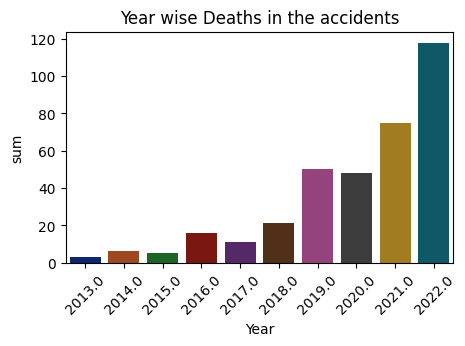

In [108]:
plt.figure(figsize=(5,3))

sns.barplot(y='sum', x='Year', hue='Year', data=tesla_df_YearDeaths, palette="dark", legend = False)
 
# Add title
plt.title("Year wise Deaths in the accidents")
plt.xticks(rotation=45)
#plt.savefig("YearwiseDeaths")
 
# Show plot
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - The bar plot above shows the number of deaths across all countries year-wise. It is observed that maximum deaths observed are in the year-2022 and minimum deaths are in the year-2013
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2013 - Country and State wise deaths
</span>

In [109]:
tesla_df_byYearCountry = tesla_df_byYear.get_group(2013)

In [110]:
tesla_df_byYearCountry

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
292,2.0,2013.0,11/2/2013,USA,CA,Tesla kills cyclist,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
293,1.0,2013.0,4/2/2013,USA,CA,Tesla veers into opposite lane,2.0,0.0,0.0,2.0,0.0,0.0,S,0.0,0.0,0.0


In [111]:
tesla_df_country_state = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry)
tesla_df_country_state


State,CA
Country,
USA,3.0


<span style="font-size:16px; color:red"> **Inferences** - In the year 2013, there were 3 deaths reported in CA state of USA
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2014 - Country and State wise deaths
</span>

In [112]:
tesla_df_byYearCountry1 = tesla_df_byYear.get_group(2014)

In [113]:
tesla_df_byYearCountry1

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
288,6.0,2014.0,12/30/2014,USA,CA,Tesla drives off cliff,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
289,5.0,2014.0,7/14/2014,USA,CA,Tesla kills motorcyclist,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
290,4.0,2014.0,7/4/2014,USA,CA,Thief crashes stolen Tesla,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
291,3.0,2014.0,7/4/2014,USA,CA,Tesla rear ends stopped car,3.0,0.0,0.0,3.0,0.0,0.0,0,0.0,0.0,0.0


In [114]:
tesla_df_country_state1 = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry1)
#tesla_df_country_state1 = tesla_df_country_state1.fillna('-')
tesla_df_country_state1


State,CA
Country,
USA,6.0


<span style="font-size:16px; color:red"> **Inferences** - In the year 2014, there were 6 deaths reported in CA state of USA
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2015 - Country and State wise deaths
</span>

In [115]:
tesla_df_byYearCountry2 = tesla_df_byYear.get_group(2015)

In [116]:
tesla_df_byYearCountry2

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
283,11.0,2015.0,12/28/2015,USA,TX,Sudden unintended acceleration into pool,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
284,10.0,2015.0,12/22/2015,Canada,-,Struck by dumptruck,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
285,9.0,2015.0,11/18/2015,USA,CA,Tesla kills pedestrian,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
286,8.0,2015.0,6/22/2015,USA,CA,Tesla drives off cliff,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
287,7.0,2015.0,1/22/2015,USA,CA,Tesla drives off cliff,1.0,1.0,0.0,0.0,0.0,1.0,S,0.0,0.0,0.0


In [117]:
tesla_df_country_state2 = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry2)
tesla_df_country_state2 = tesla_df_country_state2.fillna('-')
tesla_df_country_state2


State,CA,TX,-
Country,,,
Canada,-,-,1.0
USA,3.0,1.0,-


<span style="font-size:16px; color:red"> **Inferences** - In the year 2015, there were 5 deaths reported in USA and Canada
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2016 - Country and State wise deaths
</span>

In [118]:
tesla_df_byYearCountry3 = tesla_df_byYear.get_group(2016)

In [119]:
tesla_df_byYearCountry3

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
268,26.0,2016.0,12/20/2016,USA,CA,Tesla kills pedestrian,1.0,0.0,0.0,0.0,1.0,1.0,X,0.0,0.0,0.0
269,25.0,2016.0,11/23/2016,USA,IL,Driver dead in Winnebago County,1.0,1.0,0.0,0.0,0.0,1.0,S,0.0,0.0,0.0
270,24.0,2016.0,11/3/2016,USA,IN,Indianapolis fire,2.0,1.0,1.0,0.0,0.0,2.0,0,0.0,0.0,0.0
271,23.0,2016.0,10/10/2016,USA,NH,Pileup,1.0,0.0,0.0,1.0,0.0,0.0,S,0.0,0.0,0.0
272,22.0,2016.0,10/7/2016,USA,CA,Tesla kills motorcyclist,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
273,21.0,2016.0,9/7/2016,Holland,-,Drove into wooded ravine,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
274,20.0,2016.0,9/1/2016,USA,FL,Motorcyclist rear ends Tesla,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
275,19.0,2016.0,8/15/2016,USA,CA,Tesla rear ended,1.0,0.0,1.0,0.0,0.0,1.0,S,0.0,0.0,0.0
276,18.0,2016.0,7/29/2016,USA,FL,Tesla kills pedestrian,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
277,17.0,2016.0,7/22/2016,USA,CA,Passat strikes Tesla,1.0,0.0,0.0,1.0,0.0,0.0,S,0.0,0.0,0.0


In [120]:
tesla_df_country_state3 = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry3)
tesla_df_country_state3 = tesla_df_country_state3.fillna('-')
tesla_df_country_state3


State,CA,FL,HI,IL,IN,NH,OH,-
Country,,,,,,,,
China,-,-,-,-,-,-,-,1.0
Holland,-,-,-,-,-,-,-,1.0
USA,5.0,3.0,1.0,1.0,2.0,1.0,1.0,-


<span style="font-size:16px; color:red"> **Inferences** - In the year 2016, there were 16 deaths reported in USA, Holland and China
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2017 - Country and State wise deaths
</span>

In [121]:
tesla_df_byYearCountry4 = tesla_df_byYear.get_group(2017)

In [122]:
tesla_df_byYearCountry4

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
257,37.0,2017.0,11/22/2017,Switzerland,-,Tesla rear ends stopped car,1.0,0.0,0.0,1.0,0.0,0.0,S,0.0,0.0,0.0
258,36.0,2017.0,11/14/2017,Australia,-,Tesla kills cyclist,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
259,35.0,2017.0,9/24/2017,USA,TN,Tesla drives off road,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
260,34.0,2017.0,8/13/2017,USA,AZ,Tesla kills motorcyclist,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
261,33.0,2017.0,7/21/2017,USA,AZ,Wrong way driver strikes Tesla,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
262,32.0,2017.0,6/25/2017,USA,CA,Tesla strikes Camry,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
263,31.0,2017.0,6/10/2017,USA,HI,Unclear; see note at right,1.0,0.0,0.0,1.0,0.0,0.0,S,0.0,0.0,0.0
264,30.0,2017.0,5/11/2017,USA,FL,Tesla into oncoming traffic,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
265,29.0,2017.0,4/26/2017,Norway,-,Tesla into oncoming traffic,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
266,28.0,2017.0,3/13/2017,USA,CA,Tesla kills pedestrian,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0


In [123]:
tesla_df_country_state4 = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry4)
tesla_df_country_state4 = tesla_df_country_state4.fillna('-')
tesla_df_country_state4


State,AZ,CA,FL,HI,TN,-
Country,,,,,,
Australia,-,-,-,-,-,1.0
Germany,-,-,-,-,-,1.0
Norway,-,-,-,-,-,1.0
Switzerland,-,-,-,-,-,1.0
USA,2.0,2.0,1.0,1.0,1.0,-


<span style="font-size:16px; color:red"> **Inferences** - In the year 2017, there were 11 deaths reported in USA, Switzerland, Norway, Germany and Australia
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2018 - Country and State wise deaths
</span>

In [124]:
tesla_df_byYearCountry5 = tesla_df_byYear.get_group(2018)

In [125]:
tesla_df_byYearCountry5

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
239,55.0,2018.0,12/30/2018,USA,VA,"Early morning, single car collision",1.0,1.0,0.0,0.0,0.0,1.0,3,0.0,0.0,0.0
240,54.0,2018.0,12/26/2018,USA,NH,Burned in New Ipswich crash,1.0,0.0,1.0,0.0,0.0,1.0,X,0.0,0.0,0.0
241,53.0,2018.0,11/15/2018,Denmark,-,Tesla into oncoming traffic,1.0,0.0,0.0,1.0,0.0,0.0,S,0.0,0.0,0.0
242,52.0,2018.0,11/10/2018,USA,FL,Tesla kills motorcyclist,1.0,0.0,0.0,1.0,0.0,0.0,X,0.0,0.0,0.0
243,51.0,2018.0,11/9/2018,USA,CA,Tesla crashes into tree,2.0,0.0,2.0,0.0,0.0,2.0,S,0.0,0.0,0.0
244,50.0,2018.0,10/26/2018,Canada,-,Tesla drives off road,1.0,0.0,1.0,0.0,0.0,1.0,S,0.0,0.0,0.0
245,49.0,2018.0,9/21/2018,USA,CA,Single car collision in Anaheim on SR-91,1.0,1.0,0.0,0.0,0.0,1.0,S,0.0,0.0,0.0
246,48.0,2018.0,9/15/2018,Japan,-,Tesla rear ends stopped car,2.0,0.0,0.0,2.0,0.0,0.0,X,0.0,0.0,0.0
247,47.0,2018.0,8/4/2018,Holland,-,Tesla crashes into tree,1.0,0.0,1.0,0.0,0.0,1.0,S,0.0,0.0,0.0
248,46.0,2018.0,7/24/2018,USA,MO,Concrete falls on Tesla,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0


In [126]:
tesla_df_country_state5 = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry5)
tesla_df_country_state5 = tesla_df_country_state5.fillna('-')
tesla_df_country_state5


State,CA,FL,MO,NH,OH,VA,-
Country,,,,,,,
Canada,-,-,-,-,-,-,1.0
China,-,-,-,-,-,-,1.0
Denmark,-,-,-,-,-,-,1.0
Holland,-,-,-,-,-,-,1.0
Japan,-,-,-,-,-,-,3.0
Norway,-,-,-,-,-,-,1.0
Switzerland,-,-,-,-,-,-,1.0
USA,5.0,3.0,1.0,1.0,1.0,1.0,-


<span style="font-size:16px; color:red"> **Inferences** - In the year 2018, there were 21 deaths reported across various countries
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2019 - Country and State wise deaths
</span>

In [127]:
tesla_df_byYearCountry6 = tesla_df_byYear.get_group(2019)

In [128]:
tesla_df_byYearCountry6

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
193,101.0,2019.0,12/29/2019,USA,IN,Tesla rear ends parked fire truck,1.0,0.0,1.0,0.0,0.0,1.0,3,1.0,1.0,1.0
194,100.0,2019.0,12/29/2019,USA,CA,Tesla runs red light after exiting freeway,2.0,0.0,0.0,2.0,0.0,0.0,S,2.0,2.0,2.0
195,99.0,2019.0,12/23/2019,Slovenia,-,Drunk driver strikes Tesla,1.0,0.0,0.0,1.0,0.0,0.0,S,0.0,0.0,0.0
196,98.0,2019.0,12/19/2019,USA,FL,Police SUV strikes Tesla,2.0,1.0,1.0,0.0,0.0,2.0,0,0.0,0.0,0.0
197,97.0,2019.0,12/11/2019,USA,CA,Tesla strikes turning Lexus,1.0,0.0,0.0,1.0,0.0,0.0,X,0.0,0.0,0.0
198,96.0,2019.0,12/10/2019,USA,NV,Kia rear ends Tesla,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
199,95.0,2019.0,12/1/2019,USA,TX,Struck Ford veers into Tesla's lane,2.0,0.0,0.0,2.0,0.0,0.0,0,0.0,0.0,0.0
200,94.0,2019.0,11/24/2019,Taiwan,-,"Tesla strikes divider, driver falls to death",1.0,1.0,0.0,0.0,0.0,1.0,3,0.0,0.0,0.0
201,93.0,2019.0,11/22/2019,USA,CA,Tire strikes Tesla,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
202,92.0,2019.0,11/21/2019,USA,CA,Tesla kills pedestrian,1.0,0.0,0.0,0.0,1.0,1.0,S,0.0,0.0,0.0


In [129]:
tesla_df_country_state6 = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry6)
tesla_df_country_state6 = tesla_df_country_state6.fillna('-')
tesla_df_country_state6


State,CA,DE,FL,IA,IN,NV,OH,PA,TX,VA,-
Country,,,,,,,,,,,
Austria,-,-,-,-,-,-,-,-,-,-,1.0
Canada,-,-,-,-,-,-,-,-,-,-,1.0
Germany,-,-,-,-,-,-,-,-,-,-,5.0
Holland,-,-,-,-,-,-,-,-,-,-,1.0
Norway,-,-,-,-,-,-,-,-,-,-,1.0
Slovenia,-,-,-,-,-,-,-,-,-,-,1.0
Spain,-,-,-,-,-,-,-,-,-,-,1.0
Taiwan,-,-,-,-,-,-,-,-,-,-,1.0
USA,17.0,1.0,9.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,-


<span style="font-size:16px; color:red"> **Inferences** - In the year 2019, there were 50 deaths reported across various countries
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2020 - Country and State wise deaths
</span>

In [130]:
tesla_df_byYearCountry7 = tesla_df_byYear.get_group(2020)

In [131]:
tesla_df_byYearCountry7

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
26,268.0,2020.0,9/16/2022,USA,GA,Tesla loses control and crashes into bus shel...,1.0,0.0,0.0,0.0,1.0,1.0,0,1.0,0.0,0.0
154,140.0,2020.0,12/18/2020,Portugal,-,Tesla driver crashes into pole and dies in re...,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
155,139.0,2020.0,12/11/2020,USA,FL,"Pedestrians hit and run by Tesla, one died fr...",1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
156,138.0,2020.0,12/9/2020,South Korea,-,Car goes out of control and crashes into a wa...,1.0,0.0,1.0,0.0,0.0,1.0,X,1.0,0.0,0.0
157,137.0,2020.0,12/4/2020,USA,CA,"Car loses control, goes airborne, hits teleph...",1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0
158,136.0,2020.0,11/16/2020,USA,MO,Five-vehicle pileup involving truck,1.0,0.0,0.0,1.0,0.0,0.0,Y,0.0,0.0,0.0
159,135.0,2020.0,10/31/2020,USA,CA,"Car hit by a Tesla, driver later died from in...",1.0,0.0,0.0,1.0,0.0,0.0,Y,0.0,0.0,0.0
160,134.0,2020.0,10/10/2020,USA,CA,Motorcyclist died after rear-ending a Tesla,1.0,0.0,0.0,1.0,0.0,0.0,Y,0.0,0.0,0.0
161,133.0,2020.0,10/7/2020,Belgium,-,"Driver going wrong direction hits Tesla, driv...",1.0,0.0,0.0,1.0,0.0,0.0,3,0.0,0.0,0.0
162,132.0,2020.0,9/17/2020,USA,GA,"Car loses control, hits bus shelter",1.0,0.0,0.0,0.0,1.0,1.0,3,1.0,0.0,1.0


In [132]:
tesla_df_country_state7 = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry7)
tesla_df_country_state7 = tesla_df_country_state7.fillna('-')
tesla_df_country_state7


State,CA,FL,GA,IL,MO,NJ,OH,UT,VA,-,GA
Country,,,,,,,,,,,
Belgium,-,-,-,-,-,-,-,-,-,1.0,-
Canada,-,-,-,-,-,-,-,-,-,4.0,-
China,-,-,-,-,-,-,-,-,-,2.0,-
Germany,-,-,-,-,-,-,-,-,-,5.0,-
Netherlands,-,-,-,-,-,-,-,-,-,3.0,-
Norway,-,-,-,-,-,-,-,-,-,1.0,-
Portugal,-,-,-,-,-,-,-,-,-,1.0,-
South Korea,-,-,-,-,-,-,-,-,-,1.0,-
Taiwan,-,-,-,-,-,-,-,-,-,2.0,-


<span style="font-size:16px; color:red"> **Inferences** - In the year 2020, there were 48 deaths reported across various countries
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2021 - Country and State wise deaths
</span>

In [133]:
tesla_df_byYearCountry8 = tesla_df_byYear.get_group(2021)

In [134]:
tesla_df_byYearCountry8

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
96,198.0,2021.0,12/31/2021,USA,CA,Tesla crashes into trees,2.0,1.0,1.0,0.0,0.0,2.0,0,0.0,0.0,0.0
97,197.0,2021.0,12/28/2021,USA,CA,Multi-crash involving DUI,1.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,1.0
98,196.0,2021.0,12/24/2021,China,-,Tesla loses control and drives into river,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
99,195.0,2021.0,12/18/2021,USA,CA,Multi-car accident,1.0,0.0,0.0,1.0,0.0,0.0,Y,0.0,0.0,0.0
100,194.0,2021.0,12/11/2021,France,-,Crash in public area including 20 injuries,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
101,193.0,2021.0,12/7/2021,USA,AZ,Vehicular collision,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
102,192.0,2021.0,12/7/2021,Germany,-,"Tesla crashes into trees, flames erupt",1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
103,191.0,2021.0,12/2/2021,China,-,Motorbiker killed by Tesla,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
104,190.0,2021.0,12/1/2021,USA,CA,"Collision with pole, battery ignited",1.0,1.0,0.0,0.0,0.0,1.0,3,0.0,0.0,0.0
105,189.0,2021.0,11/29/2021,USA,CA,DUI crash with parked car,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0


In [135]:
tesla_df_country_state8 = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry8)
tesla_df_country_state8 = tesla_df_country_state8.fillna('-')
tesla_df_country_state8


State,AZ,CA,CO,FL,GA,IA,MI,NV,NY,OH,PA,TX,UT,VA,WA,-
Country,,,,,,,,,,,,,,,,
Belgium,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
China,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,7.0
Denmark,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
France,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,3.0
Germany,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0
Netherlands,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0
UK,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0
USA,8.0,14.0,1.0,7.0,3.0,1.0,2.0,1.0,4.0,2.0,3.0,3.0,2.0,4.0,2.0,-


<span style="font-size:16px; color:red"> **Inferences** - In the year 2021, there were 75 deaths reported across various countries
</span>

<span style='color:Purple; font-size:16px'> **Task** - Year:2022 - Country and State wise deaths
</span>

In [136]:
tesla_df_byYearCountry9 = tesla_df_byYear.get_group(2022)

In [137]:
tesla_df_byYearCountry9

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
4,290.0,2022.0,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,203.0,2022.0,2/12/2022,USA,CA,Tesla crashes into a tree,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
92,202.0,2022.0,2/7/2022,USA,FL,"Tesla loses control, hits pole, ignites",1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
93,201.0,2022.0,1/16/2022,USA,CA,Three-car collision near intersection,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
94,200.0,2022.0,1/1/2022,USA,CA,Motorcyclist crashes into Tesla,1.0,0.0,0.0,1.0,0.0,0.0,X,0.0,0.0,0.0


In [138]:
tesla_df_country_state9 = pd.pivot_table(index=" Country ", columns=" State ", values=" Deaths ", aggfunc="sum", data=tesla_df_byYearCountry9)
tesla_df_country_state9 = tesla_df_country_state9.fillna('-')
tesla_df_country_state9
                                                         

State,AZ,CA,CO,FL,ID,MI,MO,NC,NJ,NV,...,IL,MA,MD,ME,MO,NY,PA,SC,UT,WA
Country,,,,,,,,,,,,,,,,,,,,,
Australia,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Canada,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
China,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Finland,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Germany,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Mexico,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Netherlands,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Switzerland,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
UK,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


<span style="font-size:16px; color:red"> **Inferences** - In the year 2022, there were 118 deaths reported across various countries
</span>

In [139]:
tesla_df_byCountry = tesla_dataframe.groupby(' Country ')

In [140]:
tesla_df_grp1 = tesla_df_byCountry.get_group(' Australia ')
tesla_df_grp1

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
71,223.0,2022.0,5/12/2022,Australia,-,Tesla hit pedestrian who dies 5 days later fr...,1.0,0.0,0.0,0.0,1.0,1.0,X,0.0,0.0,0.0
258,36.0,2017.0,11/14/2017,Australia,-,Tesla kills cyclist,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0


In [141]:
# Number of accident deaths per year
print("Country-wise Deaths in the accidents : ")

Country-wise Deaths in the accidents : 


In [142]:
tesla_df_CountryDeaths = tesla_df_byCountry[' Deaths '].aggregate(['sum']).sort_values(by='sum', ascending=False)
tesla_df_CountryDeaths

,sum
Country,
USA,261.0
China,20.0
Germany,16.0
Canada,12.0
Netherlands,6.0
UK,5.0
Norway,4.0
Switzerland,3.0
Taiwan,3.0


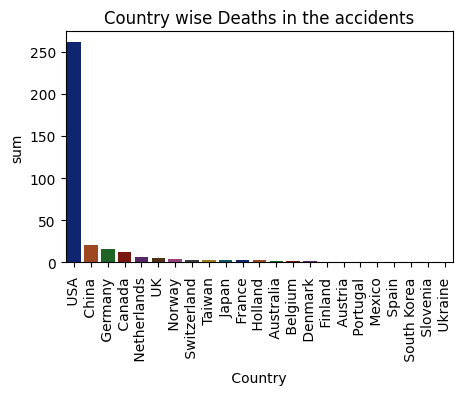

In [143]:
plt.figure(figsize=(5,3))

sns.barplot(y='sum', x=' Country ', hue=' Country ', data=tesla_df_CountryDeaths, palette='dark', legend=False)
 
# Add title
plt.title("Country wise Deaths in the accidents")
plt.xticks(rotation=90)
#plt.savefig("YearwiseDeaths")
 
# Show plot
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - In the available dataset, countrywise death toll is maximum is USA with 261 deaths. Minimum is 1 death of various countries as shown above in the bar plot
</span>

In [145]:
# Code used for debugging and testing purposes
for x, y in tesla_df_byCountry:
    print(x)
    #print(y)

 Australia 
 Austria 
 Belgium 
 Canada 
 China 
 Denmark 
 Finland 
 France 
 Germany 
 Holland 
 Japan 
 Mexico 
 Netherlands 
 Norway 
 Portugal 
 Slovenia 
 South Korea 
 Spain 
 Switzerland 
 Taiwan 
 UK 
 USA 
 Ukraine 


In [146]:
tesla_df_country_deaths = pd.pivot_table(index=" Country ", columns="Year", values=" Deaths ", aggfunc="sum", data=tesla_dataframe)
tesla_df_country_deaths = tesla_df_country_deaths.fillna('-')
tesla_df_country_deaths


Year,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
Country,,,,,,,,,,
Australia,-,-,-,-,1.0,-,-,-,-,1.0
Austria,-,-,-,-,-,-,1.0,-,-,-
Belgium,-,-,-,-,-,-,-,1.0,1.0,-
Canada,-,-,1.0,-,-,1.0,1.0,4.0,-,5.0
China,-,-,-,1.0,-,1.0,-,2.0,7.0,9.0
Denmark,-,-,-,-,-,1.0,-,-,1.0,-
Finland,-,-,-,-,-,-,-,-,-,1.0
France,-,-,-,-,-,-,-,-,3.0,-
Germany,-,-,-,-,1.0,-,5.0,5.0,2.0,3.0


In [147]:
type(tesla_df_country_deaths)

pandas.core.frame.DataFrame

In [148]:
tesla_df_country_deaths.columns

Index([2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0,
       2022.0],
      dtype='float64', name='Year')

In [149]:
# Reset index and melt the DataFrame
long_tesla_df_country_deaths = tesla_df_country_deaths.reset_index().melt(id_vars=' Country ', var_name='Year', value_name='Death Toll')
long_tesla_df_country_deaths


,Country,Year,Death Toll
0,Australia,2013.0,-
1,Austria,2013.0,-
2,Belgium,2013.0,-
3,Canada,2013.0,-
4,China,2013.0,-
...,...,...,...
225,Switzerland,2022.0,1.0
226,Taiwan,2022.0,-
227,UK,2022.0,3.0
228,USA,2022.0,93.0


In [150]:
long_tesla_df_country_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0    Country    230 non-null    object
 1   Year        230 non-null    object
 2   Death Toll  230 non-null    object
dtypes: object(3)
memory usage: 5.5+ KB


In [151]:
long_tesla_df_country_deaths.columns

Index([' Country ', 'Year', 'Death Toll'], dtype='object')

In [152]:
long_tesla_df_country_deaths['Death Toll'] = long_tesla_df_country_deaths['Death Toll'].replace(['-', ' - ', ' '], '0')


In [153]:
long_tesla_df_country_deaths[['Year', 'Death Toll']] = long_tesla_df_country_deaths[['Year', 'Death Toll']].astype('int')


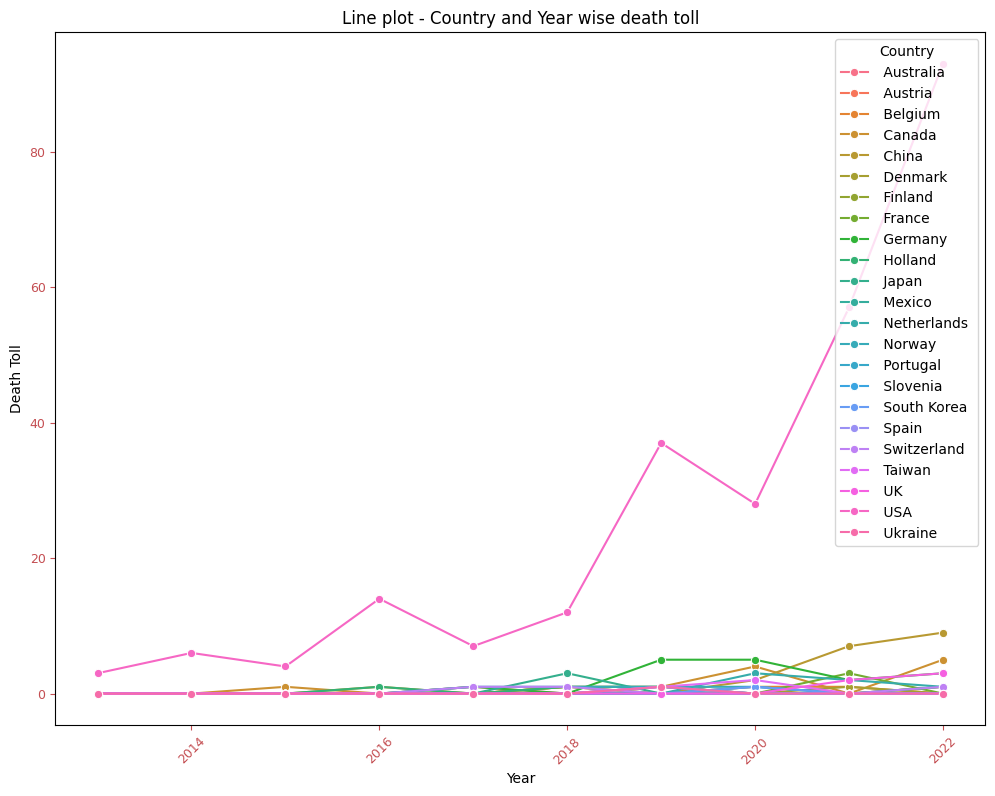

In [154]:
plt.figure(figsize=(12,9))
sns.lineplot(data=long_tesla_df_country_deaths, x='Year', y='Death Toll', hue=' Country ', marker='o')
plt.legend(title="Country", loc="upper right")
plt.title("Line plot - Country and Year wise death toll")
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize = 9, colors ='r')
#plt.savefig("Country_Year_wise_death_toll")
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - In the available dataset, country-wise and year-wise death toll is shown via the line plot. USA shows the maximum rise in the death toll in the past few years since 2020
</span>

<span style='color:Purple; font-size:16px'> **Task** - What is the number of victims (deaths) in each accident?
</span>

In [155]:
tesla_deathperaccident = tesla_dataframe.groupby('Case #')[" Deaths "].aggregate('sum')
tesla_deathperaccident.name = 'Deaths'


In [156]:
#for x,y in tesla_deathperaccident:
    #print(x)

In [157]:
type(tesla_deathperaccident)

pandas.core.series.Series

In [158]:
tesla_deathperaccident_df = pd.DataFrame(tesla_deathperaccident)
tesla_deathperaccident_df

,Deaths
Case #,
1.0,2.0
2.0,1.0
3.0,3.0
4.0,1.0
5.0,1.0
...,...
290.0,1.0
291.0,1.0
292.0,1.0


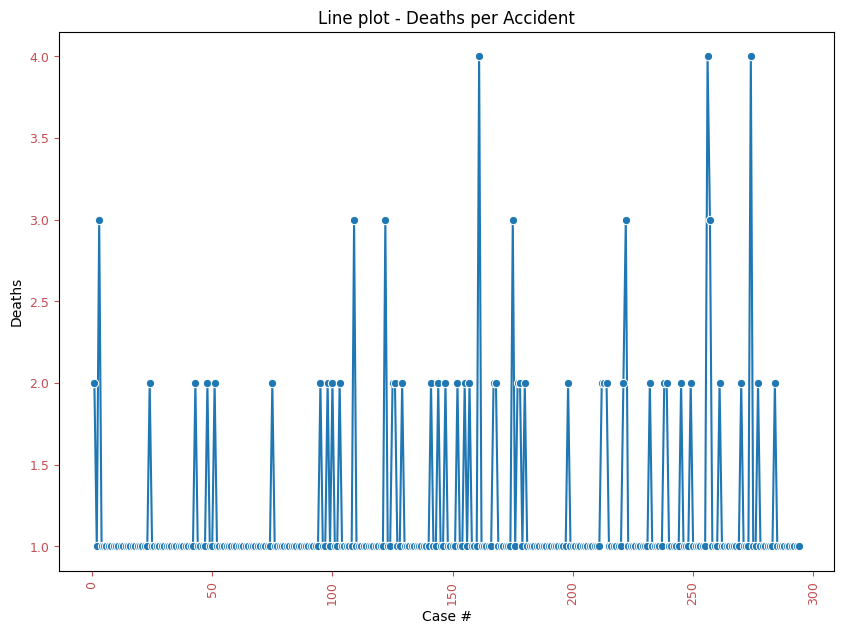

In [159]:
# Plotting Line graph for Death toll per accident
plt.figure(figsize=(10,7))
sns.lineplot(data=tesla_deathperaccident_df, x='Case #', y='Deaths', marker='o', legend=False)
plt.title("Line plot - Deaths per Accident")
plt.xticks(rotation=90)
plt.tick_params(axis='both', labelsize = 9, colors ='r')
#plt.savefig("Country_Year_wise_death_toll")
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - In the available dataset, the column 'Case #' identifies the accidents (this unique case # is given to the accident reported) and hence the groupby clause is used to figure out the number of deaths per accident and plotted as shown above in the line plot
</span>

<span style='color:Purple; font-size:16px'> **Task** - How many times did tesla drivers die?
</span>

In [160]:
tesla_dataframe.columns

Index(['Case #', 'Year', 'Date', ' Country ', ' State ', ' Description ',
       ' Deaths ', ' Tesla driver ', ' Tesla occupant ', ' Other vehicle ',
       ' Cyclists/ Peds ', ' TSLA+cycl / peds ', ' Model ',
       ' Autopilot claimed ', ' Verified Tesla Autopilot Deaths ',
       ' Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO '],
      dtype='object')

In [161]:
total_accidents = (tesla_dataframe['Case #'].unique()).shape[0]
print(type(total_accidents))
print(total_accidents)

<class 'int'>
294


In [162]:
tesla_driver_death = tesla_dataframe[' Tesla driver '].aggregate('sum')
tesla_driver_death = tesla_driver_death.astype('int')
print(tesla_driver_death)

117


In [163]:
percentage_tesla_drvr_death = ((tesla_driver_death/total_accidents)*100).round(2)
percentage_tesla_drvr_death

np.float64(39.8)

<span style="font-size:16px; color:red"> **Inferences** - 39.8% around 40% times tesla driver died in the accident
</span>

<span style='color:Purple; font-size:16px'> **Task** - What is the proportion of events in which one or more occupants died?
</span>

In [164]:
type(tesla_dataframe[' Tesla occupant '] > 0)

pandas.core.series.Series

In [165]:
(tesla_dataframe[' Tesla occupant '] > 0).sum()

np.int64(43)

In [166]:
(tesla_dataframe[tesla_dataframe[' Tesla occupant '] > 0]).shape[0]

43

In [167]:
tesla_occupant_death = (tesla_dataframe[tesla_dataframe[' Tesla occupant '] > 0]).shape[0]
print(tesla_occupant_death)

43


In [168]:
proportion = round((tesla_occupant_death/total_accidents), 2)
proportion

0.15

<span style="font-size:16px; color:red"> **Inferences** - 0.15 proportion of events in which one or more occupants died
</span>

<span style='color:Purple; font-size:16px'> **Task** - What is the distribution of events in which the vehicle hit a cyclist or a pedestrian?
</span>

In [169]:
tesla_dataframe[tesla_dataframe[' Cyclists/ Peds '] > 0]

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
4,290.0,2022.0,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
6,288.0,2022.0,12/17/2022,USA,CA,Tesla hits pedestrian on highway,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
12,282.0,2022.0,11/26/2022,USA,AR,Tesla hits pedestrian,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
17,277.0,2022.0,11/5/2022,China,-,Out of control Tesla hits bicyclist and motor...,2.0,0.0,0.0,1.0,1.0,1.0,0,0.0,0.0,0.0
26,268.0,2020.0,9/16/2022,USA,GA,Tesla loses control and crashes into bus shel...,1.0,0.0,0.0,0.0,1.0,1.0,0,1.0,0.0,0.0
36,258.0,2022.0,8/20/2022,USA,FL,Pedestrian hit in road,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
39,255.0,2022.0,8/14/2022,Finland,-,Unlicensed driver hits pedestrian,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
40,254.0,2022.0,8/2/2022,USA,FL,Man in wheelchair hit crossing road,1.0,0.0,0.0,0.0,1.0,1.0,3,0.0,0.0,0.0
41,253.0,2022.0,7/27/2022,Canada,-,Tesla hits cyclist,1.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
45,249.0,2022.0,7/12/2022,China,-,Out of control Tesla hits pedestrians,2.0,0.0,0.0,0.0,2.0,2.0,Y,0.0,0.0,0.0


In [170]:
tesla_hit_cyclist = tesla_dataframe[tesla_dataframe[' Cyclists/ Peds '] > 0][['Case #', ' Cyclists/ Peds ']]


In [171]:
tesla_hit_cyclist = tesla_hit_cyclist.reset_index()

In [172]:
tesla_hit_cyclist = tesla_hit_cyclist.drop(['index'], axis=1)

In [173]:
tesla_hit_cyclist

,Case #,Cyclists/ Peds
0,290.0,1.0
1,288.0,1.0
2,282.0,1.0
3,277.0,1.0
4,268.0,1.0
5,258.0,1.0
6,255.0,1.0
7,254.0,1.0
8,253.0,1.0
9,249.0,2.0


In [174]:
total_tesla_hit_cyclist = tesla_hit_cyclist.count()['Case #']
total_tesla_hit_cyclist

np.int64(44)

In [175]:
type(total_accidents)

int

In [176]:
percen_not_hit_cyclist = round(((total_accidents - total_tesla_hit_cyclist)/total_accidents)*100, 2)
percen_not_hit_cyclist

np.float64(85.03)

In [177]:
percem_hit_cyclist = round(((total_tesla_hit_cyclist/total_accidents)*100), 2)
percem_hit_cyclist

np.float64(14.97)

In [178]:
tesla_hit_cyclist_dict = {"Not hit Cyclist/Pedestrian" : percen_not_hit_cyclist , 
                            "Hit Cyclist/Pedestrian" : percem_hit_cyclist} 

In [179]:
tesla_hit_cyclist_series = pd.Series(tesla_hit_cyclist_dict)
tesla_hit_cyclist_series

Not hit Cyclist/Pedestrian    85.03
Hit Cyclist/Pedestrian        14.97
dtype: float64

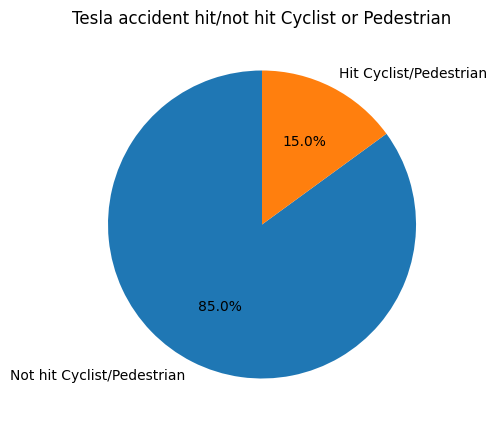

In [180]:
tesla_hit_cyclist_series.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 5), title='Tesla accident hit/not hit Cyclist or Pedestrian')
plt.show()


<span style="font-size:16px; color:red"> **Inferences** - 
- Hit Cyclist/Pedestrain is 15%
- Not Hit Cyclist/Pedestrain is 85%
</span>

<span style='color:Purple; font-size:16px'> **Task** - How many times did the accident involve the death of an occupant or driver of a Tesla along with a cyclist or pedestrian?
</span>

In [181]:
total_accidents

294

In [182]:
tesla_dataframe[(tesla_dataframe[' Tesla occupant '] > 0) | (tesla_dataframe[' Tesla driver '] > 0)]


,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
5,289.0,2022.0,12/18/2022,USA,CA,Tesla hit two other cars,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,10.0,2015.0,12/22/2015,Canada,-,Struck by dumptruck,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
286,8.0,2015.0,6/22/2015,USA,CA,Tesla drives off cliff,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
287,7.0,2015.0,1/22/2015,USA,CA,Tesla drives off cliff,1.0,1.0,0.0,0.0,0.0,1.0,S,0.0,0.0,0.0
288,6.0,2014.0,12/30/2014,USA,CA,Tesla drives off cliff,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0


In [183]:
tesla_dataframe[(tesla_dataframe[' Tesla driver '] > 0)]

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
7,287.0,2022.0,12/11/2022,USA,CA,Tesla crashes into wall,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
9,285.0,2022.0,12/6/2022,Canada,-,"Tesla veers, collides with truck",1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,10.0,2015.0,12/22/2015,Canada,-,Struck by dumptruck,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
286,8.0,2015.0,6/22/2015,USA,CA,Tesla drives off cliff,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
287,7.0,2015.0,1/22/2015,USA,CA,Tesla drives off cliff,1.0,1.0,0.0,0.0,0.0,1.0,S,0.0,0.0,0.0
288,6.0,2014.0,12/30/2014,USA,CA,Tesla drives off cliff,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0


In [184]:
tesla_driver_occupant_cyclist = tesla_dataframe[(tesla_dataframe[' Cyclists/ Peds '] > 0) & 
                                                ((tesla_dataframe[' Tesla occupant '] > 0) | (tesla_dataframe[' Tesla driver '] > 0 ))]


In [185]:
tesla_driver_occupant_cyclist


,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
116,178.0,2021.0,9/4/2021,USA,FL,"Tesla runs stop sign, crashes into house",2.0,0.0,1.0,0.0,1.0,2.0,S,0.0,0.0,0.0


<span style="font-size:16px; color:red"> **Inferences** - 1 record is found as shown above with the following condition - the accident involve the death of an occupant or driver of a Tesla along with a cyclist or pedestrian
</span>

<span style='color:Purple; font-size:16px'> **Task** - What is the frequency of Tesla colliding with other vehicles?
</span>

In [186]:
total_accidents

294

In [187]:
tesla_collide_other_vehicle = tesla_dataframe[tesla_dataframe[' Other vehicle '] > 0]

In [188]:
tesla_collide_other_vehicle

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
8,286.0,2022.0,12/11/2022,USA,MO,Collision at intersection,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
10,284.0,2022.0,11/28/2022,China,-,"Tesla runs red light, collides with two cars",2.0,0.0,0.0,2.0,0.0,0.0,Y,0.0,0.0,0.0
14,280.0,2022.0,11/12/2022,Mexico,-,Tesla hits Toyota,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
15,279.0,2022.0,11/12/2022,USA,CA,Multi-vehicle accident,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
17,277.0,2022.0,11/5/2022,China,-,Out of control Tesla hits bicyclist and motor...,2.0,0.0,0.0,1.0,1.0,1.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,16.0,2016.0,6/8/2016,USA,HI,Nissan Altima wrong way into Tesla,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
281,13.0,2016.0,4/8/2016,USA,OH,Chevy Cobalt wrong way into Tesla,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
289,5.0,2014.0,7/14/2014,USA,CA,Tesla kills motorcyclist,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0
291,3.0,2014.0,7/4/2014,USA,CA,Tesla rear ends stopped car,3.0,0.0,0.0,3.0,0.0,0.0,0,0.0,0.0,0.0


In [189]:
total_tesla_collide_other_vehicle = tesla_collide_other_vehicle.shape[0]

In [190]:
frequency_tesla_collide_other_vehicle = round((total_tesla_collide_other_vehicle / total_accidents), 2)

In [191]:
frequency_tesla_collide_other_vehicle

0.37

<span style="font-size:16px; color:red"> **Inferences** - 0.37 is the frequency of Tesla colliding with other vehicles
</span>

<span style='color:Purple; font-size:16px'> **Task** - Study the event distribution across models
</span>

In [192]:
unique_models = tesla_dataframe[' Model '].unique()

In [193]:
unique_models

array(['0', ' Y ', '  1 ', '  2 ', '  3 ', ' S ', ' X '], dtype=object)

In [194]:
unique_models_list = unique_models.tolist()
unique_models_list

['0', ' Y ', '  1 ', '  2 ', '  3 ', ' S ', ' X ']

In [195]:
# Those Accidents are filtered from the dataset if the model is present 
accident_model_series = tesla_dataframe[tesla_dataframe[' Model '] != '0'][' Model ']

In [196]:
model_distribution_series = accident_model_series.value_counts()
model_distribution_series.name = 'Frequency'
model_distribution_df = pd.DataFrame(model_distribution_series)
model_distribution_df

,Frequency
Model,
S,45
3,39
X,17
Y,10
1,1
2,1


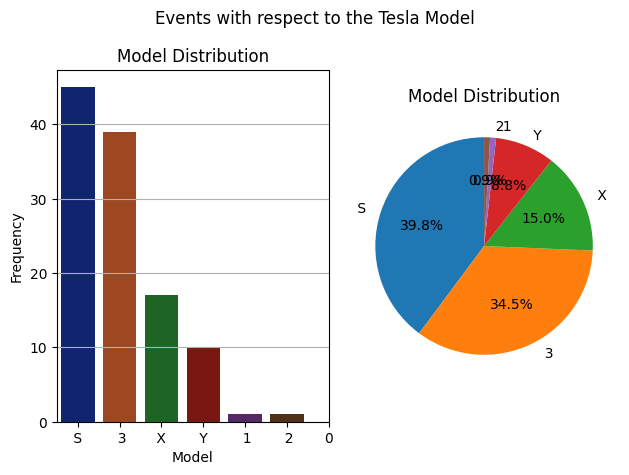

In [197]:
plt.subplot(1, 2, 1)
sns.barplot(y='Frequency', x=' Model ', hue=' Model ', data=model_distribution_df, palette='dark', legend=False)
plt.title('Model Distribution')
plt.xlabel('Model')
plt.ylabel('Frequency')
plt.xticks(ticks=unique_models_list, labels=unique_models_list, rotation=0)
plt.grid(axis='y')

# Plot the distribution of the 'Model' column as a pie chart
plt.subplot(1, 2, 2)
model_distribution_series.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 5), title='Events with respect to the Tesla Model', subplots=True)
plt.title('Model Distribution')
plt.ylabel('')

# Show the plots
plt.tight_layout()
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - The above bar plot and pie chart shows the frequency of accidents associated with each model type. It seems that model 'S' has maximum accident - 39.8% of the total events
and minimum is with model '1' and '2'</span>

<span style='color:Purple; font-size:16px'> **Task** - Check the distribution of verified Tesla autopilot deaths
</span>

In [198]:
tesla_autopilot_df = tesla_dataframe[tesla_dataframe[' Verified Tesla Autopilot Deaths '] > 0]

In [199]:
tesla_autopilot_df = tesla_autopilot_df.reset_index()

In [200]:
tesla_autopilot_df

,index,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
0,31,263.0,2022.0,8/26/2022,USA,FL,Tesla hits motorcycle,1.0,0.0,0.0,1.0,0.0,0.0,3,0.0,1.0,1.0
1,33,261.0,2022.0,8/23/2022,USA,SC,Multi-car accident on highway,2.0,0.0,0.0,2.0,0.0,0.0,3,0.0,2.0,2.0
2,43,251.0,2022.0,7/24/2022,USA,UT,Tesla hits motorcycle,1.0,0.0,0.0,1.0,0.0,0.0,3,1.0,1.0,1.0
3,48,246.0,2022.0,7/7/2022,USA,CA,Motorcycle hit by Tesla,1.0,0.0,0.0,1.0,0.0,0.0,Y,1.0,1.0,1.0
4,49,245.0,2022.0,7/6/2022,USA,FL,Tesla hits parked tractor-trailer,2.0,1.0,1.0,0.0,0.0,2.0,0,2.0,2.0,2.0
5,122,172.0,2021.0,7/26/2021,USA,NY,Pedestrian hit on shoulder,1.0,0.0,0.0,0.0,1.0,1.0,0,1.0,1.0,1.0
6,178,116.0,2020.0,5/4/2020,Norway,-,Tesla strikes and kills a man standing next t...,1.0,0.0,0.0,1.0,0.0,0.0,S,1.0,1.0,1.0
7,193,101.0,2019.0,12/29/2019,USA,IN,Tesla rear ends parked fire truck,1.0,0.0,1.0,0.0,0.0,1.0,3,1.0,1.0,1.0
8,194,100.0,2019.0,12/29/2019,USA,CA,Tesla runs red light after exiting freeway,2.0,0.0,0.0,2.0,0.0,0.0,S,2.0,2.0,2.0
9,220,74.0,2019.0,8/24/2019,USA,CA,Tesla rear ends Ford,1.0,0.0,0.0,1.0,0.0,0.0,3,1.0,1.0,1.0


In [201]:
tesla_verified_autopilot = tesla_autopilot_df[' Verified Tesla Autopilot Deaths '].count()
tesla_verified_autopilot

np.int64(16)

In [202]:
total_accidents

294

In [203]:
total_accident_deaths_df = tesla_dataframe[tesla_dataframe[' Deaths '] > 0]

In [204]:
total_accident_deaths_df = total_accident_deaths_df.reset_index()

In [205]:
total_accident_deaths_value = total_accident_deaths_df[' Deaths '].aggregate('sum')

In [206]:
total_accident_deaths_value

np.float64(353.0)

In [207]:
# As compared to total deaths in the given dataset, the percentage of Verified Auto Pilot deaths
percen_total_vs_autopilot_death = round((tesla_verified_autopilot/total_accident_deaths_value)*100, 2)
print(f"Percentage of verified autopilot deaths versua total deaths in the accidents :: {percen_total_vs_autopilot_death}%")


Percentage of verified autopilot deaths versua total deaths in the accidents :: 4.53%


In [208]:
percen_verified_autopilot_death = round((tesla_verified_autopilot/total_accidents)*100, 2)
print(f"Percentage of verified autopilot deaths :: {percen_verified_autopilot_death}%")

Percentage of verified autopilot deaths :: 5.44%


In [209]:
verified_tesla_autopilot_death = {"Verified AutoPilot Death" : percen_verified_autopilot_death , 
                            "Not Verified AutoPilot Death" : (100 - percen_verified_autopilot_death)} 

In [210]:
verified_tesla_autopilot_death_series = pd.Series(verified_tesla_autopilot_death)
verified_tesla_autopilot_death_series

Verified AutoPilot Death         5.44
Not Verified AutoPilot Death    94.56
dtype: float64

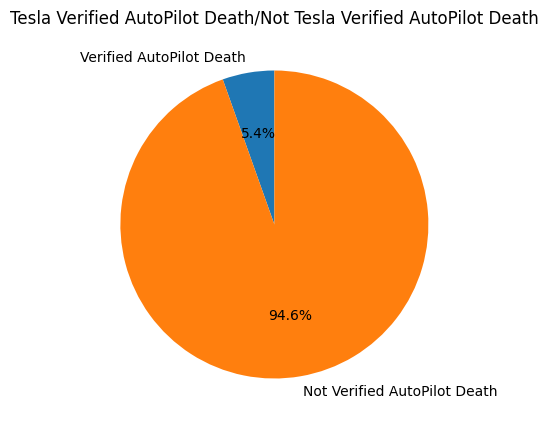

In [211]:
verified_tesla_autopilot_death_series.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 5), title='Tesla Verified AutoPilot Death/Not Tesla Verified AutoPilot Death')
plt.show()


<span style="font-size:16px; color:red"> **Inferences** - Percentage of verified autopilot deaths with respect to the total number of accidents:: 5.44% </span>